In [7]:
import torch
!pip install wandb -Uq

In [8]:
import wandb

wandb.login()

wandb: Currently logged in as: matthias-herp. Use `wandb login --relogin` to force relogin


True

In [37]:
sweep_config = {
    'method': 'random'
    }
metric = {
    'name': 'kl_divergence',
    'goal': 'minimize'
    }
sweep_config['metric'] = metric

In [38]:
parameters_dict = {
    'penvalueridge': {
        'distribution': 'uniform',
        'min': 0,
        'max': 10
      },
    'penfirstridge': {
        'distribution': 'uniform',
        'min': 0,
        'max': 10
      },
    'pensecondridge': {
        'distribution': 'uniform',
        'min': 0,
        'max': 10
      },
    }

sweep_config['parameters'] = parameters_dict

In [39]:
import pprint

pprint.pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'kl_divergence'},
 'parameters': {'penfirstridge': {'distribution': 'uniform',
                                  'max': 10,
                                  'min': 0},
                'pensecondridge': {'distribution': 'uniform',
                                   'max': 10,
                                   'min': 0},
                'penvalueridge': {'distribution': 'uniform',
                                  'max': 10,
                                  'min': 0}}}


In [40]:
sweep_id = wandb.sweep(sweep_config, project="sweeps-nf-mctm-test")

Create sweep with ID: f0lkmk88
Sweep URL: https://wandb.ai/matthias-herp/sweeps-nf-mctm-test/sweeps/f0lkmk88


In [50]:
from training_helpers import *
from nf_mctm import *
from torch.distributions.multivariate_normal import MultivariateNormal

In [51]:
def create_data(sample_num=2000):
    loc = torch.zeros(3)
    lam = torch.Tensor([[1, 0, 0],
                        [3, 1, 0],
                        [0, 0, 1]])
    scale = lam @ torch.eye(3) @ torch.transpose(lam, 0, 1)
    y_distribution = MultivariateNormal(loc, scale)
    y = y_distribution.sample((sample_num, 1))  # Generate training data
    log_likelihood = y_distribution.log_prob(y)
    y = y.reshape((sample_num, 3))

    return y,log_likelihood

In [53]:
def test(model,test_data, test_likelihood):
    z = model.forward(test_data,train=False)
    loc = torch.zeros(3)
    scale = torch.eye(3)
    y_distribution = MultivariateNormal(loc, scale)
    pred_log_likelihood = y_distribution.log_prob(z)

    kl_loss = nn.KLDivLoss(reduction="batchmean", log_target=True)
    #both input and target need to be in log likelihood
    return kl_loss(pred_log_likelihood, test_likelihood)

In [54]:
def hyperparameter_tuning(config=None):
    # Initialize a new wandb run
    with wandb.init(config=config):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config

        y_train, train_likelihood = create_data(2000)
        y_test, test_likelihood = create_data(1000)
        nf_mctm = NF_MCTM(polynomial_range=torch.tensor([[-15], [15]]),
                          number_variables=3,
                          spline_decorrelation="bspline")
        penalty_params = torch.tensor([config.penvalueridge,
                                      config.penfirstridge,
                                      config.pensecondridge])

        #no epochs required
        train(model=nf_mctm,
              train_data=y_train,
              penalty_params=penalty_params,
              iterations=200,
              verbose=False)
        kl_divergence = test(model=nf_mctm,
                             test_data=y_test,
                             test_likelihood=test_likelihood)
        wandb.log({"kl_divergence": kl_divergence})

wandb: Agent Starting Run: 1b95oj73 with config:
wandb: 	penfirstridge: 4.908471893757293
wandb: 	pensecondridge: 8.489520137240552
wandb: 	penvalueridge: 6.8143733643823605


100%|██████████| 200/200 [01:06<00:00,  3.03it/s]
/opt/anaconda3/envs/mctm_pytorch_37/lib/python3.7/site-packages/torch/nn/functional.py:2917: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."


kl_divergence,▁
kl_divergence,0.01619


wandb: Agent Starting Run: cwqfbzig with config:
wandb: 	penfirstridge: 7.273503764740443
wandb: 	pensecondridge: 5.945431007247846
wandb: 	penvalueridge: 1.9382298541075016


 66%|██████▌   | 131/200 [00:47<00:24,  2.79it/s]

Early Stop!



/opt/anaconda3/envs/mctm_pytorch_37/lib/python3.7/site-packages/torch/nn/functional.py:2917: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."


kl_divergence,▁
kl_divergence,0.01586


wandb: Agent Starting Run: upddm8xu with config:
wandb: 	penfirstridge: 5.658528937403709
wandb: 	pensecondridge: 2.887033564156974
wandb: 	penvalueridge: 0.4236399320122208


 96%|█████████▌| 192/200 [01:28<00:03,  2.18it/s]

Early Stop!



/opt/anaconda3/envs/mctm_pytorch_37/lib/python3.7/site-packages/torch/nn/functional.py:2917: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."


kl_divergence,▁
kl_divergence,0.01601


wandb: Agent Starting Run: 2erhhbhi with config:
wandb: 	penfirstridge: 9.998761098005923
wandb: 	pensecondridge: 1.3479699551597946
wandb: 	penvalueridge: 8.233071313416286


 59%|█████▉    | 118/200 [00:50<00:34,  2.35it/s]

Early Stop!



/opt/anaconda3/envs/mctm_pytorch_37/lib/python3.7/site-packages/torch/nn/functional.py:2917: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."


kl_divergence,▁
kl_divergence,0.01868


wandb: Agent Starting Run: flpyb8dh with config:
wandb: 	penfirstridge: 5.173282820405745
wandb: 	pensecondridge: 8.04658212224308
wandb: 	penvalueridge: 7.740164112413897


 57%|█████▊    | 115/200 [00:45<00:33,  2.54it/s]

Early Stop!



/opt/anaconda3/envs/mctm_pytorch_37/lib/python3.7/site-packages/torch/nn/functional.py:2917: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."


kl_divergence,▁
kl_divergence,0.01709


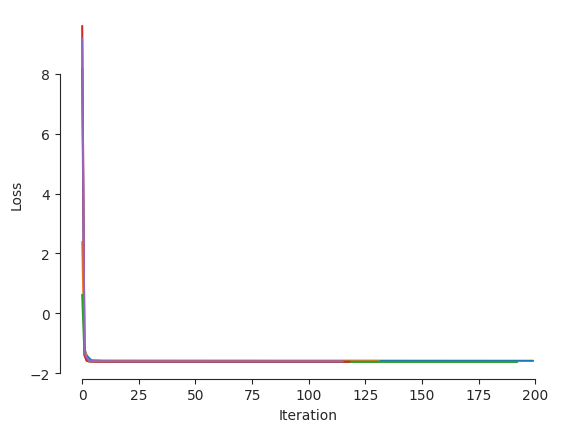

In [55]:
wandb.agent(sweep_id, hyperparameter_tuning, count=5)